  # Projet Mushroom 

  ### 1️⃣ Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib



  ### 2️⃣ EDA

In [2]:
# Charger le dataset
df = pd.read_csv("./dataset/mushroom_classification.csv", sep=';')

df.describe()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,25986,22513,22507,22527,22514,22536,22505,22587,22494,22418,...,22563,22413,22553,22489,22483,22497,22478,22493,22475,22502
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,14354,7674,7602,4810,12361,6986,17811,16092,13997,3679,...,10619,8580,8403,22489,15742,15713,8501,5085,8409,6573


 Afficher la répartition entre "Edible" et "Poisonous"

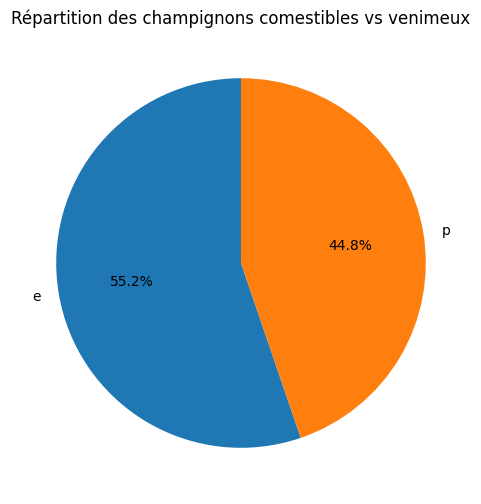

In [3]:
counts = df['class'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Répartition des champignons comestibles vs venimeux")
plt.show()


 Afficher le nombre de valeurs manquantes par categorie

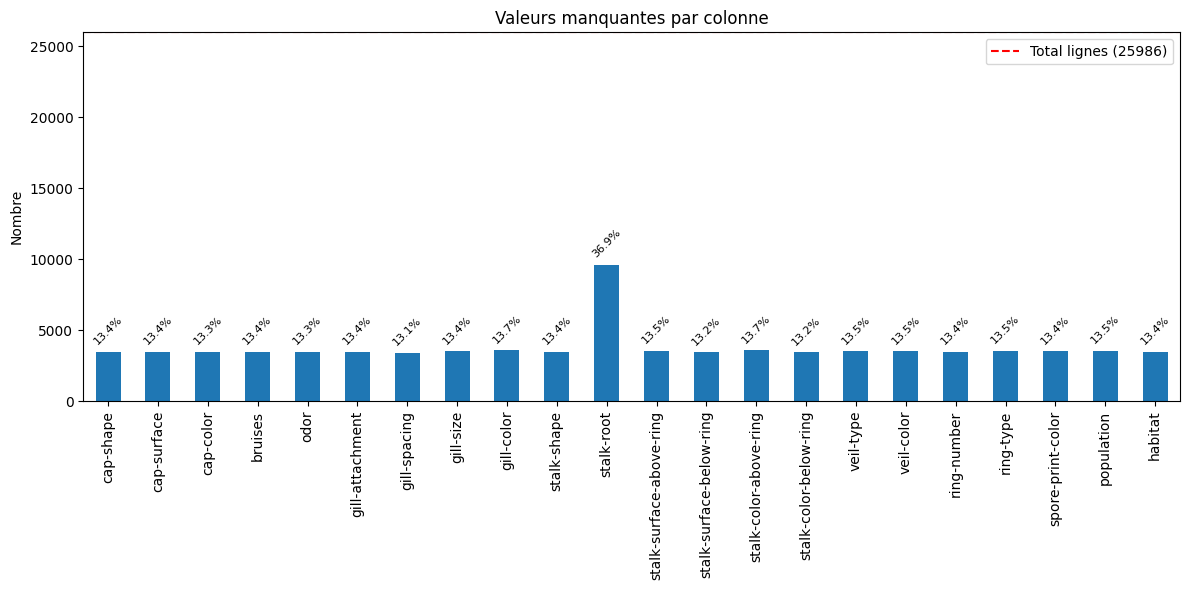

In [4]:
missing_count = df.isnull().sum()
missing_count = missing_count[missing_count > 0]
missing_pct = (missing_count / len(df)) * 100

fig, ax = plt.subplots(figsize=(12, 6))
missing_count.plot(kind='bar', ax=ax)
plt.title('Valeurs manquantes par colonne')
plt.ylabel('Nombre')
plt.ylim(0, len(df))
plt.axhline(y=len(df), color='red', linestyle='--', label=f'Total lignes ({len(df)})')

for i, (count, pct) in enumerate(zip(missing_count, missing_pct)):
    ax.text(i, count + len(df)*0.02, f'{pct:.1f}%', ha='center', rotation=45, fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()


 Analyse des colonnes les plus deterministes (Cramer's V)

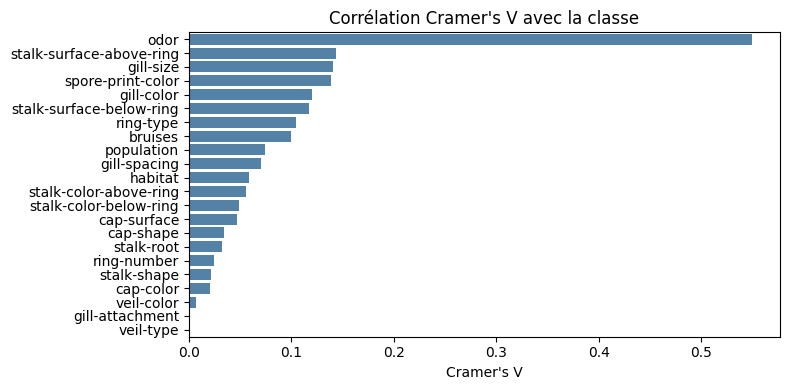

Top features : odor


In [5]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    table = pd.crosstab(x, y)
    if table.shape[0] == 1 or table.shape[1] == 1:
        return 0
    chi2 = chi2_contingency(table, correction=False)[0]
    n = table.sum().sum()
    r, k = table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

target = 'class'
features = df.drop(columns=[target]).columns

cramers = {col: cramers_v(df[col], df[target]) for col in features}
cramers = dict(sorted(cramers.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(8, 4))
sns.barplot(x=list(cramers.values()), y=list(cramers.keys()), color="steelblue")
plt.title("Corrélation Cramer's V avec la classe")
plt.xlabel("Cramer's V")
plt.tight_layout()
plt.show()

top_feature = list(cramers.keys())[0]
print(f"Top features : {top_feature}")


  ### 3️⃣ Nettoyage des données

In [6]:
# Supprimer la colonne la plus corrélée
# df = df.drop(columns=[top_feature])
# print(f"Colonne supprimée : {top_feature}")

# Remplacement des valeurs manquantes
df = df.fillna("Unknown")

# Suppression des colonnes avec trop de "Unknown" (>30%)
cols_to_drop = [col for col in df.columns if (df[col] == "Unknown").mean() > 0.3]
print("Colonnes supprimées :", cols_to_drop)
df = df.drop(columns=cols_to_drop)

# Suppression des lignes avec trop de "Unknown" (>30%)
rows_to_drop = [id for id in df.index if (df.loc[id] == "Unknown").mean() > 0.3]
print(f"Lignes supprimées : {len(rows_to_drop)}")
df = df.drop(index=rows_to_drop)

# Afficher le nombre de "Unknown" restants
unknown_count = (df == "Unknown").sum()
print(unknown_count[unknown_count > 0])


Colonnes supprimées : ['stalk-root']
Lignes supprimées : 448
cap-shape                   3329
cap-surface                 3318
cap-color                   3301
bruises                     3305
odor                        3309
gill-attachment             3331
gill-spacing                3235
gill-size                   3342
gill-color                  3400
stalk-shape                 3322
stalk-surface-above-ring    3368
stalk-surface-below-ring    3277
stalk-color-above-ring      3400
stalk-color-below-ring      3267
veil-type                   3344
veil-color                  3361
ring-number                 3325
ring-type                   3336
spore-print-color           3339
population                  3352
habitat                     3315
dtype: int64


  ### 4️⃣ Séparation features / target et train / test

In [7]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (20430, 21)
Test shape : (5108, 21)


  ### 5️⃣ Modèle Random Forest

 #### 5.1 Définir le pipeline Random Forest

In [8]:
rf_pipeline = Pipeline([
    ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5, n_estimators=200))
])


 #### 5.2 Optimisation GridSearchCV pour Random Forest

In [9]:
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [5, 10, 20],
    'classifier__min_samples_leaf': [2, 4, 8]
}

grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("✅ Meilleurs paramètres RF :", grid_search.best_params_)
print(f"✅ Meilleure accuracy CV RF : {grid_search.best_score_:.4f}")

# Garder le meilleur pipeline
best_rf_pipeline = grid_search.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits
✅ Meilleurs paramètres RF : {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
✅ Meilleure accuracy CV RF : 0.7546


 #### 5.3 Évaluation du Random Forest

In [10]:
results = {}

print("RANDOM FOREST RESULTS\n")

y_pred_train_rf = best_rf_pipeline.predict(X_train)
y_pred_test_rf = best_rf_pipeline.predict(X_test)

acc_train_rf = accuracy_score(y_train, y_pred_train_rf)
acc_test_rf = accuracy_score(y_test, y_pred_test_rf)

report_rf = classification_report(y_test, y_pred_test_rf, output_dict=True)
results['Random Forest'] = {
    'accuracy_train': acc_train_rf,
    'accuracy_test': acc_test_rf,
    'f1_mean': (report_rf['e']['f1-score'] + report_rf['p']['f1-score']) / 2
}

print(f"\nAccuracy Train : {acc_train_rf:.4f}")
print(f"Accuracy Test  : {acc_test_rf:.4f}")
print(classification_report(y_test, y_pred_test_rf, target_names=['edible', 'poisonous']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test_rf))


RANDOM FOREST RESULTS


Accuracy Train : 0.8581
Accuracy Test  : 0.7459
              precision    recall  f1-score   support

      edible       0.75      0.80      0.78      2822
   poisonous       0.73      0.68      0.70      2286

    accuracy                           0.75      5108
   macro avg       0.74      0.74      0.74      5108
weighted avg       0.75      0.75      0.74      5108

Confusion Matrix:
 [[2260  562]
 [ 736 1550]]


  ### 6️⃣ PARTIE 2 : Autres modèles 

 #### 6.1 Encoder les données explicitement

In [11]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_encoded = ohe.fit_transform(X_train)
X_test_encoded = ohe.transform(X_test)

print("Shape Train encodé :", X_train_encoded.shape)
print("Shape Test encodé  :", X_test_encoded.shape)


Shape Train encodé : (20430, 133)
Shape Test encodé  : (5108, 133)


 #### 6.2 Définir les autres modèles

In [12]:
other_models = {
    'Decision Tree': DecisionTreeClassifier(
        random_state=42, 
        max_depth=10, 
        min_samples_split=5, 
        class_weight='balanced'
    ),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(class_weight='balanced', random_state=42),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        class_weight='balanced', 
        random_state=42
    )
}


 #### 6.3 Entraînement et évaluation des autres modèles

In [13]:
print("\n" + "="*80)
print("AUTRES MODÈLES (encoding explicite)")
print("="*80)

for name, model in other_models.items():
    print(f"\n--- {name} ---")
    
    # Entraînement sur données encodées
    model.fit(X_train_encoded, y_train)
    
    # Prédictions
    y_pred_train = model.predict(X_train_encoded)
    y_pred_test = model.predict(X_test_encoded)
    
    # Accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    
    # Rapport
    report = classification_report(y_test, y_pred_test, output_dict=True)
    results[name] = {
        'accuracy_train': acc_train,
        'accuracy_test': acc_test,
        'f1_mean': (report['e']['f1-score'] + report['p']['f1-score']) / 2
    }
    
    print(f"Accuracy Train : {acc_train:.4f}")
    print(f"Accuracy Test  : {acc_test:.4f}")
    print(classification_report(y_test, y_pred_test, target_names=['edible', 'poisonous']))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))



AUTRES MODÈLES (encoding explicite)

--- Decision Tree ---
Accuracy Train : 0.7831
Accuracy Test  : 0.7067
              precision    recall  f1-score   support

      edible       0.75      0.71      0.73      2822
   poisonous       0.66      0.70      0.68      2286

    accuracy                           0.71      5108
   macro avg       0.70      0.71      0.70      5108
weighted avg       0.71      0.71      0.71      5108

Confusion Matrix:
 [[2007  815]
 [ 683 1603]]

--- AdaBoost ---
Accuracy Train : 0.7534
Accuracy Test  : 0.7412
              precision    recall  f1-score   support

      edible       0.76      0.77      0.77      2822
   poisonous       0.71      0.70      0.71      2286

    accuracy                           0.74      5108
   macro avg       0.74      0.74      0.74      5108
weighted avg       0.74      0.74      0.74      5108

Confusion Matrix:
 [[2178  644]
 [ 678 1608]]

--- Gradient Boosting ---
Accuracy Train : 0.7661
Accuracy Test  : 0.7416
     

 ============================================================================

  ### 7️⃣ Comparaison de tous les modèles

 ============================================================================


COMPARAISON DE TOUS LES MODÈLES

                     accuracy_train  accuracy_test  f1_mean
Random Forest                0.8581         0.7459   0.7409
Gradient Boosting            0.7661         0.7416   0.7379
AdaBoost                     0.7534         0.7412   0.7379
Logistic Regression          0.7533         0.7369   0.7361
SVM                          0.8493         0.7359   0.7351
Decision Tree                0.7831         0.7067   0.7049


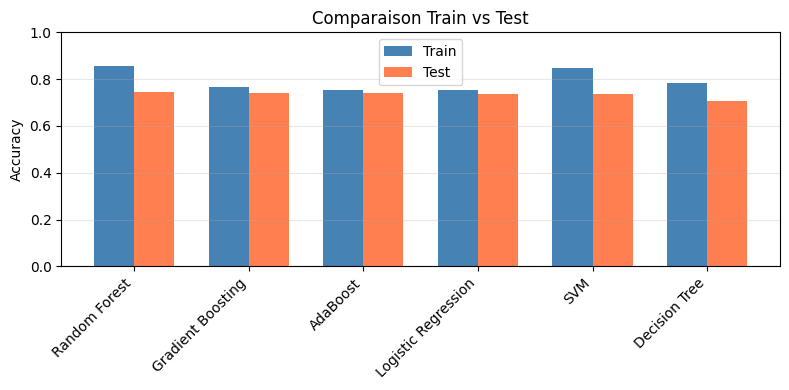


🏆 Meilleur modèle : Random Forest


In [14]:
print("\n" + "="*80)
print("COMPARAISON DE TOUS LES MODÈLES")
print("="*80 + "\n")

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('accuracy_test', ascending=False)
print(results_df.round(4))

# Graphique
fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(results_df))
width = 0.35

ax.bar(x - width/2, results_df['accuracy_train'], width, label='Train', color='steelblue')
ax.bar(x + width/2, results_df['accuracy_test'], width, label='Test', color='coral')
ax.set_ylabel('Accuracy')
ax.set_title('Comparaison Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Meilleur modèle
best_model_name = results_df['accuracy_test'].idxmax()
print(f"\n🏆 Meilleur modèle : {best_model_name}")

  ### 8️⃣ Sauvegarde du modèle Random Forest

In [15]:
model_file_name = "./models/mushroom_machine_learning.pkl"
joblib.dump(best_rf_pipeline, model_file_name)
print(f"Modele sauvegardé : {model_file_name}")
print(f"Accuracy Test : {acc_test_rf:.4f}")

Modele sauvegardé : ./models/mushroom_machine_learning.pkl
Accuracy Test : 0.7459
